<a href="https://colab.research.google.com/github/JackieUltra/MNIST/blob/main/MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Homework: Autoencoding MNIST and Celebrity Faces


> **Due Date: March 5th, 2025 @ 1:00pm**
>
> Please turn in this completed notebook via Google classroom. Email clay.smyth@ucsf.edu if you run into any issues.

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.science.org/doi/10.1126/science.1127647) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.


## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.science.org/doi/10.1126/science.1127647), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

  Limitations in computational power.

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data**

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [ ]:
# # Skip this cell if running locally
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

import os

You shouldn't need CUDA for this assignment, but if you want a head start, or if you just want to see the difference between using a CPU versus a GPU, set `use_cuda = True` below.
You can check if CUDA is available on your computer with: `torch.cuda.is_available()`

If you are working on Colab, make sure to activate the GPU ("Runtime" -> "Change runtime type...").

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(7);

> **Question 0.1) Why is it important to set the seed for the random number generator?**

For both reproducability and to make sure whatever I randomize is not changing every time I run random.anything


### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [4]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi219_downloads', train=True, download=True,
    transform=preprocessing)

test_dataset = datasets.MNIST(
    './bmi219_downloads', train=False, download=True,
    transform=preprocessing)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./bmi219_downloads/MNIST/raw/train-images-idx3-ubyte.gz to ./bmi219_downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting ./bmi219_downloads/MNIST/raw/train-labels-idx1-ubyte.gz to ./bmi219_downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./bmi219_downloads/MNIST/raw/t10k-images-idx3-ubyte.gz to ./bmi219_downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.08MB/s]

Extracting ./bmi219_downloads/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./bmi219_downloads/MNIST/raw



In [5]:
train_dataset[123][0].size()

torch.Size([1, 28, 28])

> **Q1.1) How many examples do the training set and test set have?**

> 60k train set 10k test set
...

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**

> 1 x 28 x 28, We could put this directly into a fully connected layer but this would be computationally costly and unlikely to hleo the preformance of our model much.


> **Q1.3) Why do we normalize the input data for neural networks?**

> Normalizing that data allows us to ensure that the model does not pick up on features that are more refective of how the data is demonstrated to the model instead of the data itself
...

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**

> Train your data on a training set allows you to tune and finetune your model which can then be validated on a test set to see perfrmance and start to see some degree of generalizability (given the set). Once this step occurs you should not change your model or you will begain to overfit to your test set ie data leakage will occur. By spliting the data into three sets you are able to get a few test set iterations on independent data before you validate a final model on the test set.

...

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

In [6]:
BATCH_SIZE = 64  # <-- Please change this as necessary
NUM_WORKERS = 2  # <-- Use more workers for more CPU threads

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [8]:
one_batch=next(iter(train_loader))
one_batch[0].size()

torch.Size([64, 1, 28, 28])

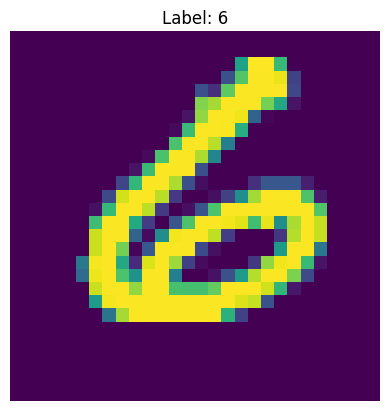

In [9]:
# Get one batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get the first batch

# Select one image in batch
image = images[0]
label = labels[0]

# Convert image tensor to numpy for visualization
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()

# Plot image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [10]:
# Get one batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get the first batch

# Print information
print(f"Type of images: {type(images)}")  # Should be a Tensor
print(f"Shape of images: {images.shape}")  # (batch_size, C, H, W)

print(f"Type of labels: {type(labels)}")  # Should be a Tensor or list
print(f"Shape of labels: {labels.shape if isinstance(labels, torch.Tensor) else 'Not a Tensor'}")

# Check a single image and label
image = images[0]
label = labels[0]

print(f"Shape of one image: {image.shape}")  # (C, H, W)
print(f"Label: {label}")  # Should be an integer or tensor


Type of images: <class 'torch.Tensor'>
Shape of images: torch.Size([64, 1, 28, 28])
Type of labels: <class 'torch.Tensor'>
Shape of labels: torch.Size([64])
Shape of one image: torch.Size([1, 28, 28])
Label: 7


> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**

> We want to make sure the model does not learn the order of the dataset when training. This does not matter when testing. In addition by shuffling the test set we may have slighly different prefromances in on our test set each time we run whihc can be confusing.

...

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**

...

> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**

> DataLoader returns both the image and the label.

...

### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[784 x 1000 x 500 x 250 x 2 x 250 x 500 x 1000 x 784]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encoder()` and a `.decoder()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [11]:
class HNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250,2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten the input
        bottleneck = self.encoder(x)  # Extract the bottleneck output
        x = self.decoder(bottleneck)  # Decode from bottleneck
        x = torch.unflatten(x, dim=1, sizes=(1, 28, 28))  # Unflatten the output
        return x, bottleneck  # Return both output and bottleneck for inspection


In [12]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Linear(800, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200,2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 800),
            nn.ReLU(),
            nn.Linear(800, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten the input
        bottleneck = self.encoder(x)  # Extract the bottleneck output
        x = self.decoder(bottleneck)  # Decode from bottleneck
        x = torch.unflatten(x, dim=1, sizes=(1, 28, 28))  # Unflatten the output
        return x, bottleneck  # Return both output and bottleneck for inspection

> **Q3.1) What activation functions did you use, and why?**

> I wanted to expirement with the leaky ReLU and also have no activation on my bottleneck to avoid limiting latent space. Mostly it was just to try something different.

...

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**.
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs).

A few useful tips:
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [13]:
def train(train_loader, model, optimizer, criterion, n_epochs, checkpoint_epochs=[5, 30, 60], save_dir="./checkpoints"):
    """
    Trains an autoencoder model.

    Parameters:
    - train_loader: DataLoader for the training dataset.
    - model: The autoencoder model.
    - optimizer: Optimization algorithm (e.g., Adam, SGD).
    - criterion: Loss function (e.g., MSELoss).
    - n_epochs: Number of training epochs
    - checkpoint_epochs: List of epochs where model checkpoints will be saved.
    - save_dir: Directory to save model checkpoints.
    """


    # Store training loss over time
    loss_history = []

    # Create directory for saving models
    os.makedirs(save_dir, exist_ok=True)

    print(f"Starting training on {device} for {n_epochs} epochs...\n")

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0

        for images, _ in train_loader:  # Ignore labels
            images = images.to(device)

            # Forward pass
            outputs, bottleneck = model(images)
            loss = criterion(outputs, images)  # Compare reconstruction with original

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute average loss for this epoch
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)

        print(f"Epoch [{epoch}/{n_epochs}], Loss: {avg_loss:.6f}")

        # Save model checkpoint at specified epochs
        if epoch in checkpoint_epochs:
            checkpoint_path = os.path.join(save_dir, f"autoencoder_epoch_{epoch}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

    print("Training complete!")

    return loss_history  # Return loss history for visualization


### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

> **Q5.1) What loss function is suited to this problem?**

> MSE works well for image reconstruction and is therefore likely a good loss function for this problem. I also want to try binary cross entropy (BCE) but would need to normalize the pixels to between 0 and 1

...

> **Q5.2) Try a few optimizers, what seemed to work best?**

> I started with the adam optimizer (momentum optimizer) I may try a SGD with and without momentum

...

> **Q5.3) What's the effect of choosing different batch sizes?**

...

In [15]:
# Define model, optimizer, loss function, epochs
modelH = HNet().to(device)
modelM = MyNet().to(device)
modelM.to(device)
optimizer = optim.Adam(modelH.parameters(), lr=1e-4)
optimizerM = optim.Adam(modelM.parameters(), lr=1e-5)
criterion = nn.MSELoss()
n_epochs = 60

### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [16]:
# Train the model
loss_history = train(train_loader, modelH, optimizer, criterion, n_epochs)

Starting training on cuda for 60 epochs...

Epoch [1/60], Loss: 0.751389


KeyboardInterrupt: 

In [ ]:
# My model
loss_historyM = train(train_loader, modelM, optimizerM, criterion, n_epochs)

Starting training on cuda for 60 epochs...

Epoch [1/60], Loss: 0.873195
Epoch [2/60], Loss: 0.758021
Epoch [3/60], Loss: 0.733447
Epoch [4/60], Loss: 0.727644
Epoch [5/60], Loss: 0.723485
Checkpoint saved at ./checkpoints/autoencoder_epoch_5.pth
Epoch [6/60], Loss: 0.719177
Epoch [7/60], Loss: 0.714566
Epoch [8/60], Loss: 0.710428
Epoch [9/60], Loss: 0.706602
Epoch [10/60], Loss: 0.703259
Epoch [11/60], Loss: 0.700230
Epoch [12/60], Loss: 0.697773
Epoch [13/60], Loss: 0.695773
Epoch [14/60], Loss: 0.693917
Epoch [15/60], Loss: 0.692155
Epoch [16/60], Loss: 0.690479
Epoch [17/60], Loss: 0.688812
Epoch [18/60], Loss: 0.687406
Epoch [19/60], Loss: 0.685929
Epoch [20/60], Loss: 0.684613
Epoch [21/60], Loss: 0.683449
Epoch [22/60], Loss: 0.682409
Epoch [23/60], Loss: 0.681496
Epoch [24/60], Loss: 0.680535
Epoch [25/60], Loss: 0.679603
Epoch [26/60], Loss: 0.678810
Epoch [27/60], Loss: 0.678044
Epoch [28/60], Loss: 0.677257
Epoch [29/60], Loss: 0.676509
Epoch [30/60], Loss: 0.675797
Checkpo

In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

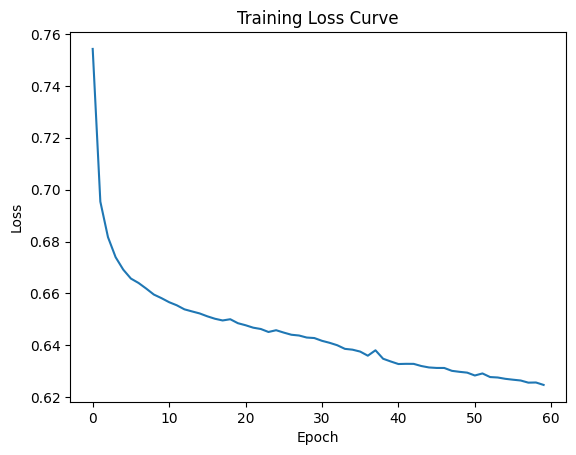

In [ ]:
# Plot Training Loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

> **Q6.1)  How do you know when your network is done training?**

...



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do.

In [ ]:
# Extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(10, mini_batch.shape[0])  # Ensure we don't exceed available samples
examples = mini_batch[:n_examples]

# Compute reconstructions and bottleneck representations
with torch.no_grad():
    reconstr_examples, bottleneck_values = modelH.forward(
        examples.view(n_examples, -1).to(device))  # Forward pass now returns both

# Save image with original vs. reconstructed images
comparison = torch.cat([
    examples,  # Original images
    reconstr_examples.view(-1, 1, 28, 28).cpu()  # Reconstructed images
])
save_image(comparison, 'training_reconstruction.png', nrow=n_examples)

# Print bottleneck values for inspection
print("Bottleneck representations:")
print(bottleneck_values.cpu().numpy())  # Convert to numpy for better readability


Bottleneck representations:
[[-7.9109659e+00 -3.8032553e+00]
 [-5.5966096e+00 -2.5640466e+00]
 [-3.2784157e+00  3.7553821e+00]
 [ 6.3771152e-01 -7.7063382e-01]
 [-1.8282951e+01 -1.6826466e+01]
 [-4.2256260e+00 -4.0442386e+00]
 [ 8.3491592e+01 -5.8121067e+01]
 [-8.3622354e-01 -2.8705370e-02]
 [-2.4819822e+00 -2.5457609e+00]
 [ 4.4247656e+00 -3.4439495e+01]]


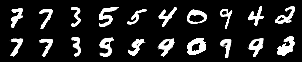

In [ ]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

...

### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


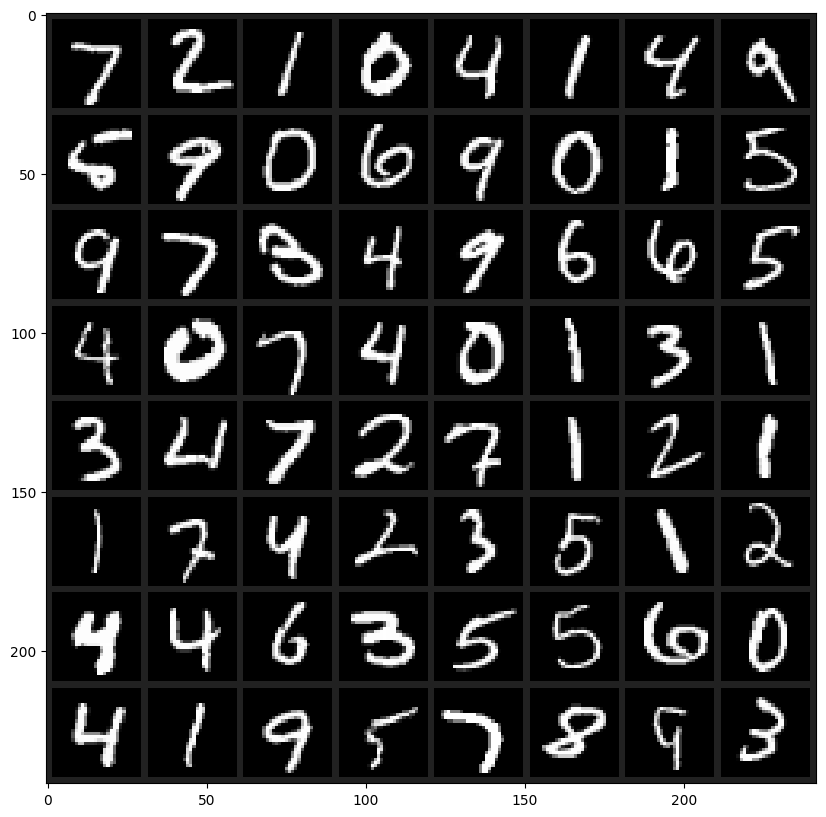

In [ ]:
### Helper Functions for Plotting Multiple Images

def imshow(inp,
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(batch)
imshow(out)

In [ ]:
# Define function to load a checkpoint and generate reconstructions
def load_checkpoint_and_reconstruct(model, test_loader, checkpoint_epochs, save_dir="./checkpoints"):
    for epoch in checkpoint_epochs:
        checkpoint_path = os.path.join(save_dir, f"autoencoder_epoch_{epoch}.pth")
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}...")
            modelH.load_state_dict(torch.load(checkpoint_path, map_location=device))
            modelH.eval()  # Set model to evaluation mode

            # Get a batch of test data
            batch, _ = next(iter(test_loader))

            with torch.no_grad():
                reconstructions = model(batch.view(batch.size(0), -1).to(device))

            # Prepare for visualization
            comparison = torch.cat([batch, reconstructions.view(-1, 1, 28, 28).cpu()])
            save_image(comparison, f"{checkpoint_path}_reconstruction.png", nrow=batch.size(0))

            print(f"Saved reconstruction comparison for {checkpoint_path}")

# List of checkpoint epochs (same as in training function)
checkpoint_epochs = [5, 30, 60]

# Run function to load and reconstruct
load_checkpoint_and_reconstruct(modelH, test_loader, checkpoint_epochs)


Loading checkpoint from ./checkpoints/autoencoder_epoch_5.pth...


<ipython-input-34-0f4b71fb0777>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelH.load_state_dict(torch.load(checkpoint_path, map_location=device))


AttributeError: 'tuple' object has no attribute 'view'

### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space.
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**.


In [ ]:
def encode(model, device, test_loader):
    model.eval()
    latent_embeddings = []
    labels = []

    with torch.no_grad():
        for batch, batch_labels in test_loader:
            batch = batch.view(batch.size(0), -1).to(device)
            encoded = model.encoder(batch)  # Extract latent space representation
            latent_embeddings.append(encoded.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())

    # Convert to numpy arrays
    latent_embeddings = np.concatenate(latent_embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_embeddings, labels

# Get latent space embeddings
latent_embeddings, labels = encode(model, device, test_loader)

# Plot latent space using matplotlib
plt.figure(figsize=(10, 8))
for digit in range(10):
    idx = labels == digit  # Find all points for this digit
    plt.scatter(latent_embeddings[idx, 0], latent_embeddings[idx, 1], label=str(digit), alpha=0.7)

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Representation (Color-coded by Label)")
plt.legend(title="Digits")
plt.show()

NameError: name 'model' is not defined

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**

...

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [ ]:
### Download faces.zip and unzip it into bmi219_downloads/

In [ ]:
preprocessing = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4401,), (0.2407,)),
])

train_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/train',
    transform=preprocessing)

test_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/test',
    transform=preprocessing)

NameError: name 'transforms' is not defined

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?